# Decode stimuli/block/licks from neural activity - DR single session

In [170]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import scipy.stats as st
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import sklearn as sk
import glob
import re
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor, compute_smoothed_response_rate

%matplotlib notebook

In [4]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed", 
    r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed",
#     r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644866_20230207\processed", 
#     r"Y:\DRpilot_644866_20230208\processed",
#     r"Y:\DRpilot_644866_20230209\processed",
#     r"Y:\DRpilot_644866_20230210\processed",
    r"Y:\DRpilot_644867_20230220\processed",
    r"Y:\DRpilot_644867_20230221\processed",
    r"Y:\DRpilot_644867_20230222\processed",
    r"Y:\DRpilot_644867_20230223\processed",
    r"Y:\DRpilot_649943_20230213\processed", 
    r"Y:\DRpilot_649943_20230214\processed",
    r"Y:\DRpilot_649943_20230215\processed",
    r"Y:\DRpilot_649943_20230216\processed",
]



## Load a single session

In [231]:
sel_session=8
session=Session(path=main_path[sel_session]) 
session.assign_unit_areas()
session=compute_smoothed_response_rate(session)

probeA areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\

In [ ]:
# trials table
session.trials

In [ ]:
# units table
session.good_units

In [ ]:
session.good_units['area'].value_counts()

In [ ]:
# spike times from one unit
session.spike_times[session.units.index[0]]

In [ ]:
# information about each frame
session.frames

In [232]:
# loop through sessions and make unit xarrays
time_before_flash = 0.5
trial_duration = 1.5
bin_size = 0.001


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              session.trials,time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": session.trials.index.values
                               })

### decode by area

In [330]:
# session.good_units['area'].value_counts()
# session.metadata

In [233]:
#shorten the area names to better lump together units
#get rig of layers and/or sub-areas with dashes
area_short = []
for area in session.good_units['area']:
    if area=='N/A':
        short='N/A'
    elif area[:2]=='CA':
        short=area
    else:
        dig_ind=re.search(r"\d", area)
        dash_ind=re.search(r"-", area)
        if dig_ind!=None:
            short=area[:dig_ind.start()]
        elif dash_ind!=None:
            short=area[:dash_ind.start()]
        else:
            short=area
        
    area_short.append(short)
    
session.good_units['area_short']=area_short

In [235]:
area_counts=session.good_units['area_short'].value_counts()
area_counts[area_counts>20].index

Index(['ProS', 'LP', 'VISl', 'MOs', 'CP', 'DG', 'RSPd', 'PoT', 'SGN', 'CA1',
       'MRN', 'VISp'],
      dtype='object')

In [9]:
session.trials

,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_rewarded,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,vis_hit_trials,...,stimLatency,trial_stim_dur,avg_run_speed,vis1_interp,sound2_interp,sound1_interp,vis2_interp,catch_interp,cross_modal_dprime,intra_modal_dprime
0,0,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.020720,0.5,17.776906,0.546012,NaN,NaN,NaN,NaN,NaN,NaN
1,674,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.020720,0.5,12.068137,0.636215,NaN,NaN,NaN,NaN,NaN,NaN
2,1044,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.022585,0.5,-0.211599,0.721164,NaN,NaN,NaN,NaN,NaN,NaN
3,1438,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.022585,0.5,0.033307,0.798030,NaN,NaN,NaN,NaN,NaN,NaN
4,1841,vis1,vis1,True,True,0.0,0.5,True,False,False,...,0.022345,0.5,0.049698,0.864853,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,213238,sound2,sound1,True,False,0.5,0.0,False,False,False,...,0.105667,0.5,16.578884,0.277474,NaN,0.606147,0.155597,NaN,0.859652,NaN
475,213592,vis2,sound1,False,False,0.0,0.5,False,True,False,...,0.022725,0.5,22.574939,0.273434,NaN,0.576080,NaN,NaN,0.794334,NaN
476,214441,sound1,sound1,True,True,0.5,0.0,False,False,False,...,0.091479,0.5,32.031784,0.269394,NaN,NaN,NaN,NaN,NaN,NaN
477,214823,vis1,sound1,False,False,0.0,0.5,True,False,False,...,0.022480,0.5,21.171312,0.265354,NaN,NaN,NaN,NaN,NaN,NaN


In [365]:
trnum='all'
u_num='all'
u_min=20
n_repeats=10
binsize=0.1
time_bins=np.arange(-0.2,0.6,binsize)
balance_labels=0
        
svc_results={}

svc_results[sel_session]={}

#exclude any trials that had opto stimulation
if 'trialOptoVoltage' in session.trials.columns:
    trial_sel = session.trials.query('trialOptoVoltage.isnull()').index
else:
    trial_sel = session.trials.index

predict=['stim_ids','block_ids','trial_response']

# grab the stimulus ids
stim_ids = session.trials['trialStimID'][trial_sel].values
# or, use block IDs
block_ids = session.trials['trialstimRewarded'][trial_sel].values
#or, use whether mouse responded
trial_response = session.trials['trial_response'][trial_sel].values

svc_results[sel_session]['metadata']=session.metadata
svc_results[sel_session]['trial_numbers']=trnum
svc_results[sel_session]['unit_numbers']=u_num
svc_results[sel_session]['min_n_units']=u_min
svc_results[sel_session]['n_repeats']=n_repeats
svc_results[sel_session]['time_bins']=time_bins
svc_results[sel_session]['balance_labels']=balance_labels

# for p in predict:
# area_sel=['all']
p='block_ids'
svc_results[sel_session][p]={}


#choose what variable to predict
if p=='stim_ids':
    pred_var = stim_ids
elif p=='block_ids':
    pred_var = block_ids
elif p=='trial_response':
    pred_var = trial_response
        
area_sel = area_counts[area_counts>=u_min].index
# area_sel = ['VISp','MOs']

for aa in area_sel:
    if aa=='all':
        unit_sel = session.good_units.index.values
    else:
        unit_sel = session.good_units.query('area_short==@aa').index.values
#         unit_sel = session.good_units.query('area_short.str.contains(@aa)').index.values
    svc_results[sel_session][p][aa]={}
    svc_results[sel_session][p][aa]['n_units']=len(unit_sel)
    
    for tt,t_start in enumerate(time_bins[:-1]):
        svc_results[sel_session][p][aa][tt]={}
        for nn in range(0,n_repeats):
            svc_results[sel_session][p][aa][tt][nn]={}
            
            if u_num=='all':
                unit_subset = np.random.choice(unit_sel,len(unit_sel),replace=False)
            else:
                unit_subset = np.random.choice(unit_sel,u_num,replace=False)

            if balance_labels:
                subset_ind=[]
                conds = np.unique(pred_var)
                cond_count=[]

                if trnum=='all':
                    for cc in conds:
                        cond_count.append(np.sum(pred_var==cc))
                    use_trnum=np.min(cond_count)
                else:
                    use_trnum = trnum

                for cc in conds:
                    cond_inds=np.where(pred_var==cc)[0]
                    if len(cond_inds)<use_trnum:
                        use_trnum=len(cond_inds)
                    subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False))   
                subset_ind=np.sort(np.hstack(subset_ind))

                trial_sel=trial_sel[subset_ind]
                pred_var=pred_var[subset_ind]

                
            sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                            trials=trial_sel,
                                            unit_id=unit_subset).mean(dim='time').values
            
            svc_results[sel_session][p][aa][tt][nn]=custom_decoder(
                input_data=sel_data.T,
                labels=pred_var.flatten())
            
            svc_results[sel_session][p][aa][tt][nn]['shuffle']=custom_decoder(
                input_data=sel_data.T,
                labels=np.random.choice(pred_var,len(pred_var),replace=False).flatten())
            
            
            svc_results[sel_session][p][aa][tt][nn]['trial_sel_idx']=trial_sel

            
    print(aa+' done')

            
# savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results'

# with open(os.path.join(savepath,'decoder_results_100ms_incl_all_trials.pkl'), 'wb') as handle:
#     pickle.dump(svc_results, handle, protocol=pickle.HIGHEST_PROTOCOL)        

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VISp done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

MOs done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [354]:
def custom_decoder(input_data,labels):
    
    output={}
    
    scaler = StandardScaler()
    skf = StratifiedKFold(n_splits=5,shuffle=True)
    
    scaler.fit(sel_data.T)
    X = scaler.transform(input_data)
    y = labels
 
    if type(y[0])==bool:
        ypred=np.full(len(y), fill_value=False)
    elif type(y[0])==str:
        ypred=np.full(len(y), fill_value='       ')
    else:
        ypred=np.full(len(y), fill_value=np.nan)

    tidx_used=[]

    for train,test in skf.split(X, y):
        clf=svm.LinearSVC()
        clf.fit(X[train],y[train])
        ypred[test] = clf.predict(X[test])
        tidx_used.append([test])

    cr_dict=classification_report(y, ypred, output_dict=True)
    cr_df=pd.DataFrame.from_dict(cr_dict)

    output['cr']=cr_df
    output['pred_label']=ypred
    output['true_label']=y
    output['trial_sel_idx']=trial_sel
    output['trials_used']=tidx_used
    
    return output


def reformat_decoder_results(area_sel,svc_results,timepoints,n_repeats):
    # make into more plottable format
    plot_results={}
    timepoints=time_bins[1:]
    areas=area_sel

    for aa in areas:
        plot_results[aa]={}
        plot_results[aa]['vis1']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['vis1'][:]=np.nan
        plot_results[aa]['vis2']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['vis2'][:]=np.nan
        
        plot_results[aa]['aud1']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['aud1'][:]=np.nan
        plot_results[aa]['aud2']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['aud2'][:]=np.nan
        
        plot_results[aa]['True']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['True'][:]=np.nan
        plot_results[aa]['False']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['False'][:]=np.nan


    for aa in areas: #svc_results[ss]['results'].keys():
        if aa in svc_results.keys():
            for tt,tp in enumerate(timepoints):

                for nn in range(0,n_repeats):
                    if 'vis1' in svc_results[aa][tt][nn].keys():
                        vis1_perf=np.mean(svc_results[aa][tt][nn]['vis1'][['precision','recall']].values)
                        plot_results[aa]['vis1'][tt,nn]=vis1_perf
                        
                    if 'vis2' in svc_results[aa][tt][nn].keys():
                        vis1_perf=np.mean(svc_results[aa][tt][nn]['vis2'][['precision','recall']].values)
                        plot_results[aa]['vis2'][tt,nn]=vis1_perf

                    if 'sound1' in svc_results[aa][tt][nn].keys():
                        aud1_perf=np.mean(svc_results[aa][tt][nn]['sound1'][['precision','recall']].values)
                        plot_results[aa]['aud1'][tt,nn]=aud1_perf
                        
                    if 'sound2' in svc_results[aa][tt][nn].keys():
                        aud1_perf=np.mean(svc_results[aa][tt][nn]['sound2'][['precision','recall']].values)
                        plot_results[aa]['aud2'][tt,nn]=aud1_perf
                        
                    if 'True' in svc_results[aa][tt][nn].keys():
                        vis1_perf=np.mean(svc_results[aa][tt][nn]['True'][['precision','recall']].values)
                        plot_results[aa]['True'][tt,nn]=vis1_perf

                    if 'False' in svc_results[aa][tt][nn].keys():
                        aud1_perf=np.mean(svc_results[aa][tt][nn]['False'][['precision','recall']].values)
                        plot_results[aa]['False'][tt,nn]=aud1_perf
                        
    return plot_results

In [355]:
pred_var

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True,  True, False,  True,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
       False, False,  True, False, False, False,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True, False,
       False, False, False,  True,  True, False, False,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True, False, False, False, False, False,  True,
        True, False, False,  True,  True, False, False, False,  True,
       False, False,  True, False, False, False,  True,  True,  True,
       False, False, False, False, False, False, False,  True,  True,
        True, False,  True, False, False,  True, False, False, False,
       False,  True,

In [356]:
pred_var_int=np.zeros(len(pred_var)).astype(int)
unique_vals=np.unique(pred_var)
for iu,uu in enumerate(unique_vals):
    pred_var_int[pred_var==uu]=iu
    
pred_var_recon=np.full(len(pred_var),fill_value='       ')
for iu,uu in enumerate(unique_vals):
    pred_var_recon[pred_var_int==iu]=uu
    
pred_var_recon==pred_var

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_17972\406259429.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  pred_var_recon==pred_var


False

In [350]:
skf = StratifiedKFold(n_splits=5)
for train,test in skf.split(X, y):
    print('ntrain:',len(train),' ntest:',len(test))

ntrain: 412  ntest: 103
ntrain: 412  ntest: 103
ntrain: 412  ntest: 103
ntrain: 412  ntest: 103
ntrain: 412  ntest: 103


In [297]:
np.mean(y[train]=='sound1')

0.4878640776699029

In [296]:
# session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
#                                         trials=trial_sel,
#                                         unit_id=unit_subset).mean(dim='time').values
# np.mean(ypred == 'sound1')

In [372]:
svc_results[sel_session]['block_ids']['MOs'][0][0]['shuffle']
# svc_results[0]['stim_ids']
# svc_results[0]['trial_response']

{'cr':                sound1        vis1  accuracy   macro avg  weighted avg
 precision    0.460526    0.491289   0.47767    0.475908      0.476296
 recall       0.418327    0.534091   0.47767    0.476209      0.477670
 f1-score     0.438413    0.511797   0.47767    0.475105      0.476031
 support    251.000000  264.000000   0.47767  515.000000    515.000000,
 'pred_label': array(['sound1', 'vis1', 'sound1', 'sound1', 'vis1', 'vis1', 'vis1',
        'vis1', 'sound1', 'sound1', 'sound1', 'vis1', 'vis1', 'vis1',
        'vis1', 'vis1', 'vis1', 'sound1', 'sound1', 'sound1', 'vis1',
        'sound1', 'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'sound1',
        'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'sound1', 'vis1', 'sound1',
        'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'sound1', 'vis1',
        'sound1', 'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'vis1', 'vis1',
        'sound1', 'sound1', 'vis1', 'sound1', 'vis1', 'vis1', 'vis1',
        'vis1', 'sound1', 'sound1', 'sound1'

In [279]:
# predict_perf=np.zeros((len(session.trials),n_repeats))
# predict_perf[:]=np.nan
# for nn in range(0,n_repeats):
#     tridx=np.hstack(svc_results[sel_session]['block_ids']['MOs'][0][nn]['trials_used'][np.sort(np.hstack(svc_results[sel_session]['block_ids']['MOs'][0][nn]['trials_used']))]
#     predict_perf[tridx,nn]=(svc_results[sel_session]['block_ids']['MOs'][0][nn]['pred_label']==svc_results[sel_session]['block_ids']['MOs'][0][nn]['true_label'])

In [358]:
# np.nanmean(predict_perf,1)

<IPython.core.display.Javascript object>


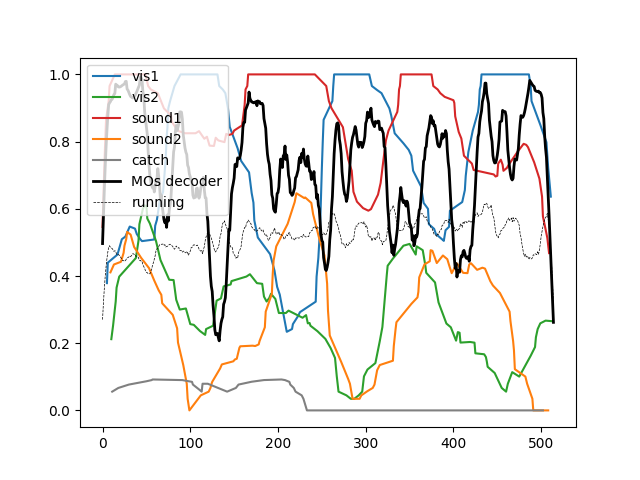

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_17972\2168155618.py:37: RuntimeWarning: Mean of empty slice
  mean_dprime=np.nanmean(session.trials[['cross_modal_dprime','intra_modal_dprime']].values,axis=1)


<IPython.core.display.Javascript object>


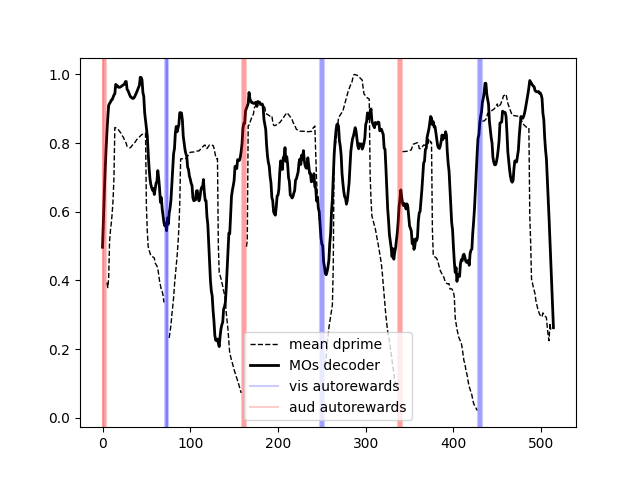

In [375]:
plot_area='MOs'

predict_perf=np.zeros((len(trial_sel),n_repeats))
for nn in range(0,n_repeats):
    predict_perf[:,nn]=(svc_results[sel_session]['block_ids'][plot_area][0][nn]['pred_label']==
                       svc_results[sel_session]['block_ids'][plot_area][0][nn]['true_label'])

# predict_perf=np.zeros((len(session.trials),n_repeats))
# predict_perf[:]=np.nan
# for nn in range(0,n_repeats):
#     tridx=np.hstack(svc_results[sel_session]['block_ids']['MOs'][0][nn]['trials_used'][
#         np.sort(np.hstack(svc_results[sel_session]['block_ids']['MOs'][0][nn]['trials_used']))]
#     predict_perf[tridx,nn]=(svc_results[sel_session]['block_ids']['MOs'][0][nn]['pred_label']==
#                        svc_results[sel_session]['block_ids']['MOs'][0][nn]['true_label'])

trials_to_smooth=5
gwindow = sg.gaussian(trials_to_smooth*3, std=trials_to_smooth)
decoder_smoothed=sg.convolve(np.mean(predict_perf,1),gwindow,mode='same')/np.sum(gwindow)

fig,ax=plt.subplots()
stim_list=['vis1','vis2','sound1','sound2','catch']
stim_array=np.asarray(stim_list)

colors=np.asarray(['tab:blue','tab:green','tab:red','tab:orange','grey'])
for ss in stim_array:
    plot_color=colors[stim_array==ss][0]
    ax.plot(np.arange(0,len(session.trials)),session.trials[ss+'_interp'],color=plot_color)
    
ax.plot(np.arange(0,len(session.trials)),decoder_smoothed,'k',linewidth=2)

ax.plot(sg.convolve(session.trials['avg_run_speed']
                        /session.trials['avg_run_speed'].max(),
                        gwindow,mode='same')/np.sum(gwindow),'k--',linewidth=0.5)

ax.legend(stim_list+[plot_area+' decoder','running'])

mean_dprime=np.nanmean(session.trials[['cross_modal_dprime','intra_modal_dprime']].values,axis=1)
mean_dprime=mean_dprime/np.nanmax(mean_dprime)

fig,ax=plt.subplots()
# ax.plot(np.arange(0,len(session.trials)),(session.trials['cross_modal_dprime']-session.trials['cross_modal_dprime'].min())/
#         session.trials['cross_modal_dprime'].max(),'k--',linewidth=1)
# ax.plot(np.arange(0,len(session.trials)),session.trials['intra_modal_dprime'],'b--',linewidth=1.5)       
ax.plot(np.arange(0,len(session.trials)),mean_dprime,'k--',linewidth=1)


ax.plot(np.arange(0,len(session.trials)),decoder_smoothed,'k',linewidth=2)

for xx in range(0,len(vis_autorewards)):
        ax.axvline(vis_autorewards[xx],color='b',alpha=0.2)
        ax.axvline(aud_autorewards[xx],color='r',alpha=0.2)
        if xx==0:
            ax.legend(['mean dprime',plot_area+' decoder',
                      'vis autorewards','aud autorewards'])

vis_autorewards=session.trials.query('vis_autoreward_trials == True').index.values
aud_autorewards=session.trials.query('aud_autoreward_trials == True').index.values



In [278]:
session.good_units['area'].unique()

array(['CL', 'LP', 'DG-mo', 'DG-sg', 'DG-po', 'CA1', 'RSPv6b', 'RSPd6a',
       'RSPd5', 'PoT', 'SGN', 'ProS', 'VISp6a', 'VISp5', 'MRN', 'APN',
       'MB', 'SCig', 'VISp4', 'VISp2/3', 'N/A', 'NB', 'SUB', 'VISl6a',
       'VISl5', 'VISl4', 'VISl2/3', 'CP', 'MOs6b', 'MOs6a', 'MOs5',
       'MOs2/3'], dtype=object)

In [367]:
notnan=~np.isnan(mean_dprime)

st.pearsonr(mean_dprime[notnan],decoder_smoothed[notnan])

PearsonRResult(statistic=0.38056809239862005, pvalue=4.65404888054624e-18)

<IPython.core.display.Javascript object>


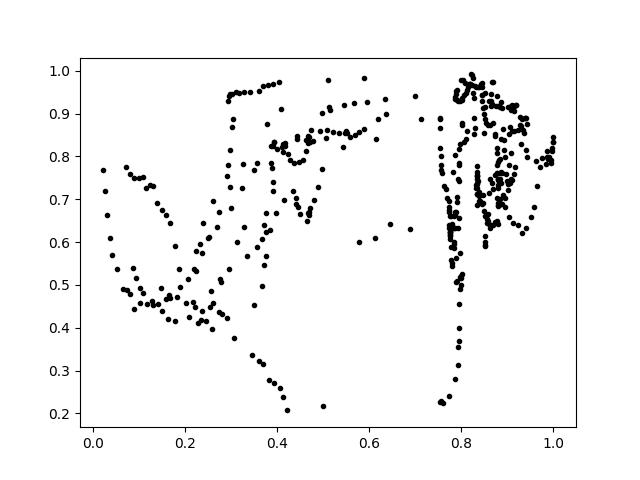

In [369]:
fig,ax=plt.subplots()
ax.plot(mean_dprime[notnan],decoder_smoothed[notnan],'k.')

In [306]:
mean_dprime=np.nanmean(session.trials[['cross_modal_dprime','intra_modal_dprime']].values,axis=1)
mean_dprime=mean_dprime/np.nanmax(mean_dprime)
mean_dprime

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_17972\1834911919.py:1: RuntimeWarning: Mean of empty slice
  mean_dprime=np.nanmean(session.trials[['cross_modal_dprime','intra_modal_dprime']].values,axis=1)


array([       nan,        nan,        nan,        nan,        nan,
       0.39340679, 0.37877099, 0.40776553, 0.51332826, 0.54493321,
       0.56737999, 0.59583124, 0.63489624, 0.69871914, 0.84533738,
       0.84427766, 0.8432185 , 0.84215985, 0.83881248, 0.83546995,
       0.83213065, 0.828793  , 0.82286825, 0.81931373, 0.81576563,
       0.80808143, 0.80422074, 0.79903359, 0.79002109, 0.78871621,
       0.78740847, 0.78609742, 0.78710178, 0.79045875, 0.7938132 ,
       0.79716671, 0.8005209 , 0.80219255, 0.80614443, 0.81009271,
       0.81271576, 0.81533916, 0.81796316, 0.82058805, 0.82285106,
       0.82489939, 0.82591179, 0.82692547, 0.82794053, 0.82895705,
       0.61580062, 0.54394031, 0.49857233, 0.48832274, 0.47984471,
       0.47205326, 0.47028544, 0.46861545, 0.46703907, 0.46536926,
       0.45041975, 0.44607432, 0.44179748, 0.43456298, 0.41601752,
       0.39808366, 0.38469658, 0.37209374, 0.36767736, 0.3557764 ,
       0.33568532,        nan,        nan,        nan,        

In [168]:
sk.metrics.balanced_accuracy_score(ypred,y)

0.701886252192276

In [167]:
sk.metrics.multilabel_confusion_matrix(ypred,y)

array([[[198,  80],
        [ 62, 139]],

       [[139,  62],
        [ 80, 198]]], dtype=int64)

In [ ]:
# u_num

In [55]:
# make into more plottable format

####change this to deal with multiple #s of trials and average over re-runs of the SVC

plot_results={}

timepoints=time_bins[1:]

label_list=['vis1','vis2','sound1','sound2','True','False']
# label_list=['vis1','sound1','True','False']

predict=['stim_ids','block_ids','trial_response']

areas=['VISp','AUD','MOs','MRN','CP']

for sel_session, path in enumerate(main_path):
    plot_results[sel_session]={}
    for aa in areas:
        plot_results[sel_session][aa]={}
        for p in predict:
            plot_results[sel_session][aa][p]={}
            for ll in label_list:
                plot_results[sel_session][aa][p][ll]=np.zeros((len(timepoints),n_repeats))
                plot_results[sel_session][aa][p][ll][:]=np.nan

    
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

decoder_acc_session_mean = {}
for aa in areas:
    decoder_acc_session_mean[aa]={}
    for p in predict:
        decoder_acc_session_mean[aa][p]={}
        for ll in label_list:
            
            decoder_acc_session_mean[aa][p][ll]=np.zeros((len(timepoints),
                                                           len(main_path)))
            decoder_acc_session_mean[aa][p][ll][:]=np.nan
        

for sel_session, path in enumerate(main_path):
    for p in predict:
        for aa in areas: 
            if aa in svc_results[sel_session][p].keys():
                for tt,tp in enumerate(timepoints):
                    for nn in range(0,n_repeats):
                        for ll in label_list:
                            if len(svc_results[sel_session][p][aa])>0:
                                if len(svc_results[sel_session][p][aa][tt])>0:
                                    if ll in svc_results[sel_session][p][aa][tt][nn].keys():
                                        temp_perf=np.nanmean(svc_results[sel_session][p]
                                                          [aa][tt][nn][ll]
                                                          [['precision','recall']].values)
                                        plot_results[sel_session][aa][p][ll][tt,nn]=temp_perf

                    for ll in label_list:
                        if len(svc_results[sel_session][p][aa])>0:                    
#                             concat_results = np.concatenate((plot_results[sel_session][aa][p][ll][tt],
#                                                              plot_results[sel_session][aa][p][ll][tt]),
#                                                             axis=2)
#                             decoder_acc_mean = np.nanmean(concat_results,2)
                            decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
                            decoder_acc_session_mean[aa][p][ll][tt,sel_session] = decoder_acc_mean
    
    
# plot_results[area][label/stimulus][timepoint_idx][ntrials_idx,nunits_idx,n_repeats]

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_38464\453054498.py:64: 

In [38]:
# plot_results[sel_session][aa][p][ll][tt]
plot_results[sel_session].keys()

dict_keys(['VISp', 'AUD', 'MOs', 'MRN', 'CP'])

In [59]:
np.nanmean(decoder_acc_session_mean['VISp']['block_ids']['vis1'],axis=1)

array([0.52513835, 0.52239889, 0.56363314, 0.54482639, 0.56191609,
       0.58114277, 0.58405977])

<IPython.core.display.Javascript object>


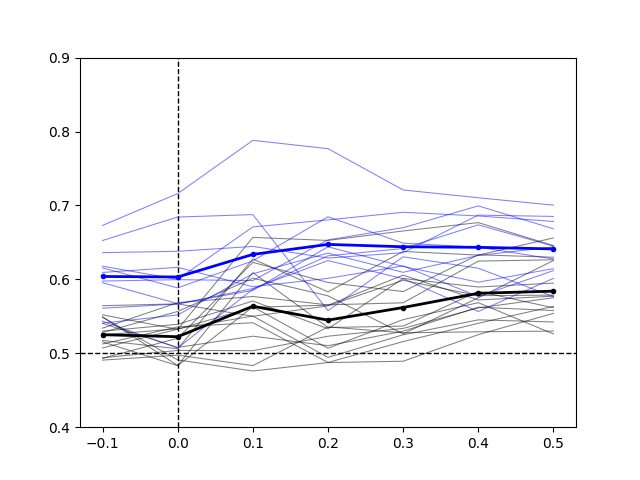

(0.4, 0.9)

In [103]:
predict_var='block_ids'
sel_stim='vis1'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
ax.axhline(0.5,color='k',linestyle='--',linewidth=1)

ax.plot(time_bins[1:],decoder_acc_session_mean['VISp'][predict_var][sel_stim],'k',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['AUD'][predict_var][sel_stim],'m',linewidth=0.75,alpha=0.5)
ax.plot(time_bins[1:],decoder_acc_session_mean['MOs'][predict_var][sel_stim],'b',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['MRN'][predict_var][sel_stim],'r',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['CP'][predict_var][sel_stim],'g',linewidth=0.75,alpha=0.5)


ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['VISp'][predict_var][sel_stim],axis=1)
        ,'k.-',linewidth=2)
# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['AUD'][predict_var][sel_stim],axis=1)
#         ,'m.-',linewidth=2)
ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)
        ,'b.-',linewidth=2)
# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['MRN'][predict_var][sel_stim],axis=1)
#         ,'r.-',linewidth=2)
# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['CP'][predict_var][sel_stim],axis=1)
#         ,'g.-',linewidth=2)


ax.set_ylim([0.4,0.9])

In [84]:
decoder_acc_session_mean['AUD']

{'stim_ids': {'vis1': array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan]]),
  'sound1': array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, 

In [96]:
predict_var='block_ids'
sel_stim='vis1'
st.ranksums(decoder_acc_session_mean['VISp'][predict_var][sel_stim][0,:],
            decoder_acc_session_mean['MOs'][predict_var][sel_stim][0,:],
            nan_policy='omit')

RanksumsResult(statistic=-3.898363792636631, pvalue=9.684484941074864e-05)

In [101]:
np.sum(~np.isnan(decoder_acc_session_mean['MOs'][predict_var][sel_stim][0,:]))

11